# Integrated gradients on huge model


## All your imports are belong to us
`import.STONKS()`

In [3]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

# from torchsummary import summary NOTE not known
import requests
from PIL import Image

#Using VGG-19 pretrained model for image classification

model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

## Download photo to work with


In [4]:
def download(url,fname):
    response = requests.get(url)
    with open(fname,"wb") as f:
        f.write(response.content)
    
# Downloading the image    
download("https://www.losanimales.org/wp-content/uploads/2018/03/Bulldog-Ingles.jpg","somePic.jpg")

# Opening the image
img = Image.open('somePic.jpg') 

Preseccing of the image. Normalising, rearange range of image, and converting to tensor

In [10]:
# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

'''
    Y = (X - μ)/(σ) => Y ~ Distribution(0,1) if X ~ Distribution(μ,σ)
    => Y/(1/σ) follows Distribution(0,σ)
    => (Y/(1/σ) - (-μ))/1 is actually X and hence follows Distribution(μ,σ)
'''
def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

### VGG19 Classes

Downloads the designated classes for the VGG19 network.

In [11]:
# Using the download function (which was previously defined)
download("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt","classes_VGG19.txt")

# Then the "open" keyword opens the txt-file.
f = open('classes_VGG19.txt', 'r')
vgg19_classes = f.read()

# Finally the split function splits the string 
# at some recurring string (in this case the newline keyword)
vgg19ClassList = vgg19_classes.split("\n")
print(f"length of classes: {len(vgg19ClassList)}")
# print(vgg19ClassList)


length of classes: 1000
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'horned

In [14]:
import difflib
nmbOfCloseMatches = 10
desiredLikeness = 0.6
closeMatches = difflib.get_close_matches('cat', vgg19ClassList, n=nmbOfCloseMatches, cutoff=desiredLikeness)
print(closeMatches)

indx = 153
print(f"class at index {indx}: {vgg19ClassList[153]}")

['crate', 'oxcart', 'castle', 'carton', 'cab', 'ant', 'polecat']
class at index 153: Maltese dog


Creating the saliency map.

In [6]:
# preprocess the image
X = preprocess(img)

# we would run the model in evaluation mode
model.eval()

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad_()

# Then there is this weird function definition
# (I am unsure what it does)
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input, target=labels[ind], **kwargs)
    
    return tensor_attributions
        

# This is then supposed to be calculating the gradients for the saliency maps
# (and also transposing the image for some reason..)
saliency = Saliency(model)
grads = saliency.attribute(input, target=labels[ind].item())
# Here I think it just sorts out the stuff with the channels
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))   


# This applies the integrated gradient attribution algorithm.
# (Don't know entirely what is supposed to be doing either).
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))


# Some more attribution algorithms:
# with some kind of standard Gaussian noise
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(
    nt, input, baselines=input * 0, nt_type='smoothgrad_sq', nt_samples=100, stdevs=0.2
    )
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))


# Something called deeplift:
dl = DeepLift(model)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0)) 



NameError: name 'labels' is not defined

In [1]:
# Using the download function (which was previously defined)
download("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt","classes_VGG19.txt")

# Then the "open" keyword opens the txt-file.
f = open('classes_VGG19.txt', 'r')
vgg19_classes = f.read()

# Finally the split function splits the string 
# at some recurring string (in this case the newline keyword)
vgg19ClassList = vgg19_classes.split("\n")
print(f"length of classes: {len(vgg19ClassList)}")
print(vgg19ClassList)




NameError: name 'download' is not defined

### Homebrewed Softmax function

I don't know why I just wanted to know what the SoftMax function looked like, so here I made it... kinda.

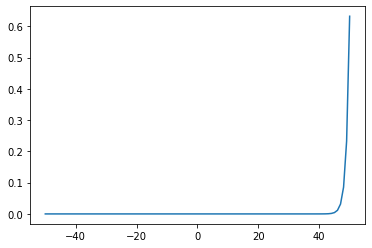

In [15]:
def softMax(numbers: list):
    from math import exp
    expSum = sum([exp(number) for number in numbers])
    softMaxOfNumbers = [exp(number)/expSum for number in numbers]
    
    return softMaxOfNumbers

numbies = list(range(-50,51))
softMaxOfNumbies = softMax(numbies)

plt.plot(numbies, softMaxOfNumbies)
    